# GPSFluxForecast Version 0
Brian Larsen, LANL, balarsen@lanl.gov



In [5]:
%load_ext version_information

The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


In [6]:
import datetime
from pprint import pprint

import spacepy.plot as spp
import path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from spacepy import omni
from spacepy import time as spt
from spacepy import plot as spp
spp.revert_style()
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
import tqdm
from scipy import stats
import matplotlib
from sklearn.neighbors import KDTree
import tqdm 
from spacepy import omni as omni
from spacepy import toolbox as tb
from spacepy import time as spt
from spacepy import datamodel as dm
import scipy

import verify

%version_information numpy, matplotlib, version_information, verify, scipy, sklearn, seaborn, spacepy

Software,Version
Python,3.7.0 64bit [Clang 4.0.1 (tags/RELEASE_401/final)]
IPython,7.0.1
OS,Darwin 17.7.0 x86_64 i386 64bit
numpy,1.15.2
matplotlib,3.0.0
version_information,1.0.3
verify,The 'verify' distribution was not found and is required by the application
scipy,1.1.0
sklearn,0.20.0
seaborn,0.9.0


## OMNI needed on 8 hour cadence
* Times are given as bin start times

In [7]:
# tb.update(omni=True, omni2=True)

In [8]:
# need ticktocks over the time interval to her 8 hour averaged OMNI
times = pd.DatetimeIndex(start='2001-01-01', end='2018-01-01', freq='8H')
tt_times = spt.Ticktock(times.to_pydatetime())
pprint(tt_times[0:4])

Ticktock( [datetime.datetime(2001, 1, 1, 0, 0) datetime.datetime(2001, 1, 1, 8, 0)
 datetime.datetime(2001, 1, 1, 16, 0) datetime.datetime(2001, 1, 2, 0, 0)], dtype=UTC)


In [9]:
# get the omni data
om = omni.get_omni(tt_times)
om.keys()

dict_keys(['ByIMF', 'Bz1', 'Bz2', 'Bz3', 'Bz4', 'Bz5', 'Bz6', 'BzIMF', 'DOY', 'Dst', 'G', 'Kp', 'Pdyn', 'RDT', 'W', 'akp3', 'dens', 'velo', 'ticks', 'UTC', 'Hr', 'Year', 'Qbits'])

In [10]:
# build a pandas dataframe of the Omnni data
keys = ['BzIMF', 'Dst', 'Kp', 'Pdyn', 'akp3', 'dens', 'velo', ] # 'ticks']

om_df = pd.DataFrame(data=om[keys])
om_df.index = pd.DatetimeIndex(om['ticks'].UTC)
om_df.head()

,BzIMF,Dst,Kp,Pdyn,akp3,dens,velo
2001-01-01 00:00:00,-0.7,-6.0,0.0,0.88,0.11,5.8,293.0
2001-01-01 08:00:00,-1.7,-2.0,1.0,1.55,0.50,11.1,285.0
2001-01-01 16:00:00,0.9,9.0,0.3,1.43,0.55,10.7,274.0
2001-01-02 00:00:00,1.3,-3.0,1.3,2.07,0.73,13.9,285.0
2001-01-02 08:00:00,0.9,11.0,0.0,1.53,0.42,10.8,272.0


In [11]:
om_df.dropna(inplace=True)

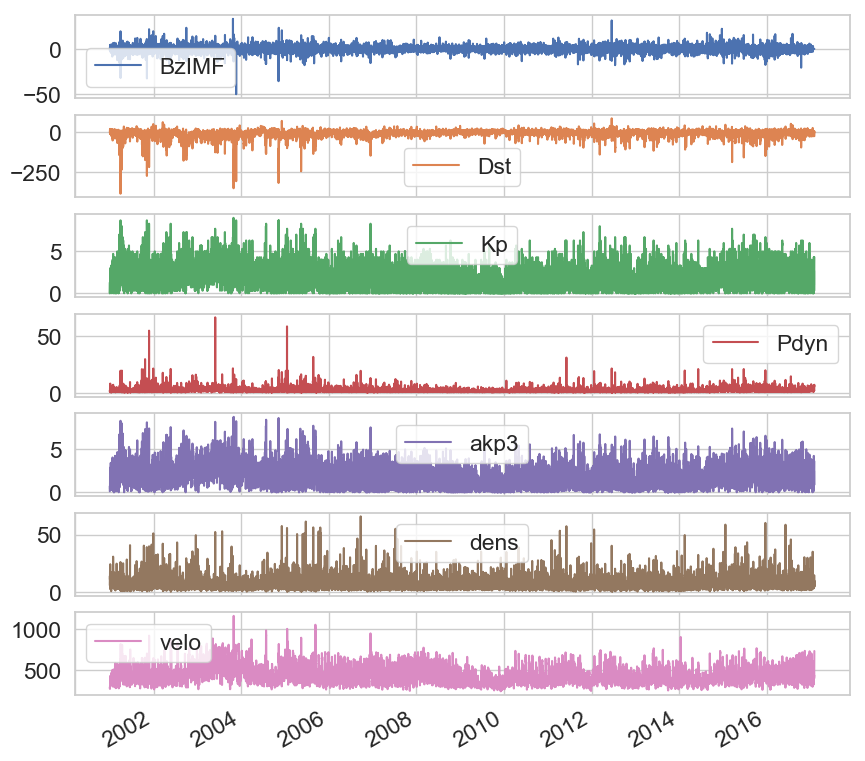

In [12]:
om_df.plot(figsize=(10,10), subplots=True);

## Need to get some events
* define 10 events, 5 storm and 5 non storm

In [13]:
np.random.seed(20161210)
storm_events = om_df.loc[om_df['Dst'] < -75, :].sample(5).index.to_pydatetime()
quiet_events = om_df.loc[om_df['Dst'] > -20, :].sample(5).index.to_pydatetime()
events = np.hstack((storm_events, quiet_events))
events.sort()
events

# array([datetime.datetime(2001, 4, 2, 0, 0),
#        datetime.datetime(2004, 5, 4, 0, 0),
#        datetime.datetime(2004, 7, 25, 16, 0),
#        datetime.datetime(2005, 6, 13, 0, 0),
#        datetime.datetime(2006, 10, 23, 8, 0),
#        datetime.datetime(2009, 9, 11, 16, 0),
#        datetime.datetime(2011, 7, 9, 0, 0),
#        datetime.datetime(2011, 7, 26, 8, 0),
#        datetime.datetime(2011, 9, 27, 0, 0),
#        datetime.datetime(2013, 7, 6, 16, 0)], dtype=object)

array([datetime.datetime(2001, 4, 2, 0, 0),
       datetime.datetime(2004, 5, 4, 0, 0),
       datetime.datetime(2004, 7, 25, 16, 0),
       datetime.datetime(2005, 6, 13, 0, 0),
       datetime.datetime(2006, 10, 23, 8, 0),
       datetime.datetime(2009, 9, 11, 16, 0),
       datetime.datetime(2011, 7, 9, 0, 0),
       datetime.datetime(2011, 7, 26, 8, 0),
       datetime.datetime(2011, 9, 27, 0, 0),
       datetime.datetime(2013, 7, 6, 16, 0)], dtype=object)

In [14]:
# Get the Data for the Events, this is Kp 7 days before and 21 days after
event_data = []
for ee in events:
    event_data.append(om_df.loc[ee-datetime.timedelta(hours=7*24+8):ee+datetime.timedelta(hours=21*24)]['Kp'])
len(event_data)

10

In [15]:
event_data[0]

2001-03-25 16:00:00    1.0
2001-03-26 00:00:00    0.3
2001-03-26 08:00:00    0.7
2001-03-26 16:00:00    0.7
2001-03-27 00:00:00    4.0
2001-03-27 08:00:00    2.0
2001-03-27 16:00:00    3.3
2001-03-28 00:00:00    3.0
2001-03-28 08:00:00    5.3
2001-03-28 16:00:00    5.7
2001-03-29 00:00:00    3.7
2001-03-29 08:00:00    4.7
2001-03-29 16:00:00    4.0
2001-03-30 00:00:00    2.3
2001-03-30 08:00:00    2.7
2001-03-30 16:00:00    2.7
2001-03-31 00:00:00    6.7
2001-03-31 08:00:00    8.7
2001-03-31 16:00:00    8.0
2001-04-01 00:00:00    5.0
2001-04-01 08:00:00    5.3
2001-04-01 16:00:00    3.0
2001-04-02 00:00:00    4.7
2001-04-02 08:00:00    3.7
2001-04-02 16:00:00    4.0
2001-04-03 00:00:00    2.3
2001-04-03 08:00:00    1.3
2001-04-03 16:00:00    2.7
2001-04-04 00:00:00    2.3
2001-04-04 08:00:00    2.0
                      ... 
2001-04-13 08:00:00    3.3
2001-04-13 16:00:00    5.0
2001-04-14 00:00:00    4.3
2001-04-14 08:00:00    3.3
2001-04-14 16:00:00    3.3
2001-04-15 00:00:00    2.7
2

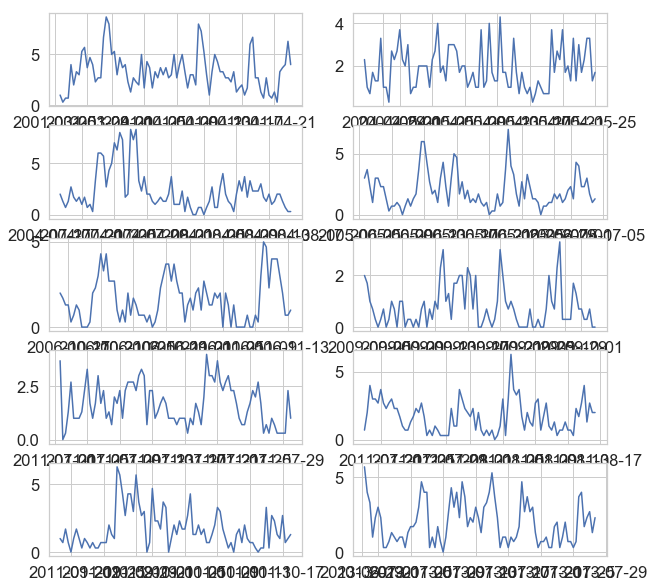

In [13]:
fig, ax = plt.subplots(5,2, figsize=(10,10))
for ii, a in enumerate(ax.flatten()):
    a.plot(event_data[ii])

## Load the CXD data

* Load the data
    * do any needed cleaning (none needed)
    * change times form bin centers to bin starts
* Fill in the K-D tree
* Prove we have it loaded right

In [52]:
CXD_dfile = '../Data/CXDdata_L4p25toL4p5.h5'
CXD = dm.fromHDF5(CXD_dfile)
CXD.tree(verbose=1)

+
|____Flux_0.425 (spacepy.datamodel.dmarray (17349,))
|____Flux_1.0 (spacepy.datamodel.dmarray (17349,))
|____Flux_1.6 (spacepy.datamodel.dmarray (17349,))
|____UTC (spacepy.datamodel.dmarray (17349,))


In [53]:
CXD['UTC'][0:5]

dmarray([b'2001-01-01T04:00:00', b'2001-01-01T12:00:00',
         b'2001-01-01T20:00:00', b'2001-01-02T04:00:00',
         b'2001-01-02T12:00:00'], dtype='|S35')

In [54]:
pd.DatetimeIndex(np.asarray(CXD['UTC'][0:5], dtype=str))

DatetimeIndex(['2001-01-01 04:00:00', '2001-01-01 12:00:00',
               '2001-01-01 20:00:00', '2001-01-02 04:00:00',
               '2001-01-02 12:00:00'],
              dtype='datetime64[ns]', freq=None)

In [55]:
CXD = pd.DataFrame({'Flux_1.6':CXD['Flux_1.6']}, index=pd.DatetimeIndex(np.asarray(CXD['UTC'], dtype=str)))
CXD.dropna(inplace=True)
CXD.head()

,Flux_1.6
2001-02-20 12:00:00,43069.021355
2001-02-20 20:00:00,27193.231000
2001-02-21 04:00:00,14515.348125
2001-02-21 12:00:00,24432.734140
2001-02-21 20:00:00,23571.599474


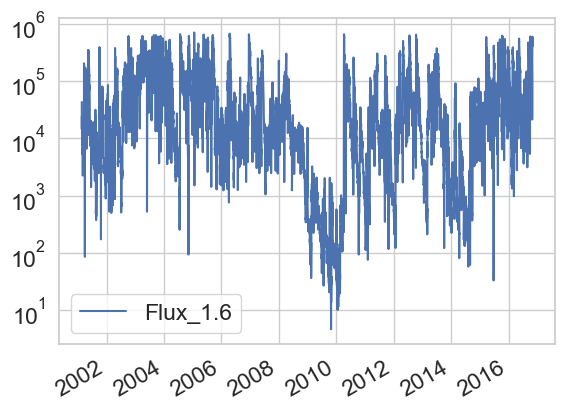

In [56]:
CXD.plot(logy=True)

In [57]:
CXD['Log_Flux_1.6'] = np.log10(CXD['Flux_1.6'])
CXD['Log_Flux_1.6_std'] = (CXD['Log_Flux_1.6']-CXD['Log_Flux_1.6'].mean())/CXD['Log_Flux_1.6'].std()
CXD.head()

,Flux_1.6,Log_Flux_1.6,Log_Flux_1.6_std
2001-02-20 12:00:00,43069.021355,4.634165,0.471567
2001-02-20 20:00:00,27193.231000,4.434461,0.254677
2001-02-21 04:00:00,14515.348125,4.161827,-0.041419
2001-02-21 12:00:00,24432.734140,4.387972,0.204187
2001-02-21 20:00:00,23571.599474,4.372389,0.187263


### Change bin center times to bin start times
Makes it easier to pull out data between stamps

In [59]:
CXD.index -= datetime.timedelta(hours=4)

In [61]:
CXD.sort_index(inplace=True)
CXD.head()

,Flux_1.6,Log_Flux_1.6,Log_Flux_1.6_std
2001-02-20 08:00:00,43069.021355,4.634165,0.471567
2001-02-20 16:00:00,27193.231000,4.434461,0.254677
2001-02-21 00:00:00,14515.348125,4.161827,-0.041419
2001-02-21 08:00:00,24432.734140,4.387972,0.204187
2001-02-21 16:00:00,23571.599474,4.372389,0.187263


In [63]:
CXD.index[0].to_pydatetime()

datetime.datetime(2001, 2, 20, 8, 0)

In [14]:
# build all vectors of now and the 7 days before
T0 = CXD.index[0].to_pydatetime()
dT = datetime.timedelta(hours=8)
T1 = CXD.index[-1].to_pydatetime()
nDays = 7
dTdays = datetime.timedelta(days=7)

T = T0
vectors = pd.DataFrame()
for i in range(-176, 1, 8):
    vectors[i] = 0.0
len_vectors = len(vectors.columns)
for ii in tqdm.tqdm(range(len_vectors)):
    t = pd.DatetimeIndex(start='2001-01-01', end=om_df.index[-1], freq=dT+dTdays)
    t += dT * ii
    for tt in t:
        tmp = om_df['Kp'].loc[tt:tt+dT+dTdays].dropna()
        if len(tmp) != len_vectors:
            continue
        vectors.loc[tt+dT+dTdays] = om_df['Kp'].loc[tt:tt+dT+dTdays].values



100%|██████████| 23/23 [00:39<00:00,  1.76s/it]


In [15]:
vectors.describe()

,-176,-168,-160,-152,-144,-136,-128,-120,-112,-104,...,-72,-64,-56,-48,-40,-32,-24,-16,-8,0
count,17603.000000,17603.000000,17603.000000,17603.000000,17603.000000,17603.000000,17603.000000,17603.000000,17603.000000,17603.000000,...,17603.000000,17603.000000,17603.000000,17603.000000,17603.000000,17603.000000,17603.000000,17603.000000,17603.000000,17603.000000
mean,1.796262,1.796262,1.796319,1.796359,1.796285,1.796285,1.796381,1.796461,1.796574,1.796762,...,1.796705,1.796819,1.796898,1.796881,1.796841,1.796841,1.796841,1.796921,1.797052,1.797182
std,1.382710,1.382710,1.382698,1.382665,1.382727,1.382727,1.382681,1.382751,1.382874,1.382949,...,1.382974,1.382966,1.382920,1.382919,1.382952,1.382952,1.382952,1.382964,1.382997,1.383125
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.700000,0.700000,0.700000,0.700000,0.700000,0.700000,0.700000,0.700000,0.700000,0.700000,...,0.700000,0.700000,0.700000,0.700000,0.700000,0.700000,0.700000,0.700000,0.700000,0.700000
50%,1.700000,1.700000,1.700000,1.700000,1.700000,1.700000,1.700000,1.700000,1.700000,1.700000,...,1.700000,1.700000,1.700000,1.700000,1.700000,1.700000,1.700000,1.700000,1.700000,1.700000
75%,2.700000,2.700000,2.700000,2.700000,2.700000,2.700000,2.700000,2.700000,2.700000,2.700000,...,2.700000,2.700000,2.700000,2.700000,2.700000,2.700000,2.700000,2.700000,2.700000,2.700000
max,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,...,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000


In [16]:
vectors.iloc[0]

-176    0.0
-168    1.0
-160    0.3
-152    1.3
-144    0.0
-136    0.3
-128    2.3
-120    2.3
-112    0.7
-104    2.3
-96     3.0
-88     3.0
-80     1.7
-72     0.7
-64     0.3
-56     2.0
-48     1.0
-40     1.0
-32     2.0
-24     1.3
-16     1.0
-8      2.0
 0      1.0
Name: 2001-01-08 08:00:00, dtype: float64

In [17]:
om_df['Kp'].loc[T0:T0+dT+dTdays]

2001-01-01 00:00:00    0.0
2001-01-01 08:00:00    1.0
2001-01-01 16:00:00    0.3
2001-01-02 00:00:00    1.3
2001-01-02 08:00:00    0.0
2001-01-02 16:00:00    0.3
2001-01-03 00:00:00    2.3
2001-01-03 08:00:00    2.3
2001-01-03 16:00:00    0.7
2001-01-04 00:00:00    2.3
2001-01-04 08:00:00    3.0
2001-01-04 16:00:00    3.0
2001-01-05 00:00:00    1.7
2001-01-05 08:00:00    0.7
2001-01-05 16:00:00    0.3
2001-01-06 00:00:00    2.0
2001-01-06 08:00:00    1.0
2001-01-06 16:00:00    1.0
2001-01-07 00:00:00    2.0
2001-01-07 08:00:00    1.3
2001-01-07 16:00:00    1.0
2001-01-08 00:00:00    2.0
2001-01-08 08:00:00    1.0
Name: Kp, dtype: float64

In [18]:
vectors.values.shape

(17603, 23)

In [19]:
# drop the events from the vectors
vectors.iloc[0]

-176    0.0
-168    1.0
-160    0.3
-152    1.3
-144    0.0
-136    0.3
-128    2.3
-120    2.3
-112    0.7
-104    2.3
-96     3.0
-88     3.0
-80     1.7
-72     0.7
-64     0.3
-56     2.0
-48     1.0
-40     1.0
-32     2.0
-24     1.3
-16     1.0
-8      2.0
 0      1.0
Name: 2001-01-08 08:00:00, dtype: float64

In [20]:
exclude = []
for ev in events:
    exclude.extend(pd.DatetimeIndex(start=ev-(dT+dTdays), end=ev, freq=dT).to_pydatetime())
for ee in exclude:
    vectors = vectors[vectors.index != ee]

In [21]:
vectors.describe()

,-176,-168,-160,-152,-144,-136,-128,-120,-112,-104,...,-72,-64,-56,-48,-40,-32,-24,-16,-8,0
count,17373.000000,17373.00000,17373.000000,17373.000000,17373.000000,17373.000000,17373.000000,17373.000000,17373.000000,17373.000000,...,17373.000000,17373.000000,17373.000000,17373.000000,17373.000000,17373.000000,17373.000000,17373.000000,17373.000000,17373.000000
mean,1.793634,1.79406,1.794348,1.794843,1.795050,1.795579,1.795643,1.796195,1.796955,1.797721,...,1.796863,1.796650,1.796633,1.796270,1.796201,1.795706,1.795890,1.795528,1.794831,1.794273
std,1.381491,1.38140,1.381389,1.381526,1.382073,1.383026,1.383166,1.383689,1.383954,1.384074,...,1.383539,1.383367,1.383030,1.382305,1.381782,1.380851,1.381115,1.380470,1.379367,1.378175
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.700000,0.70000,0.700000,0.700000,0.700000,0.700000,0.700000,0.700000,0.700000,0.700000,...,0.700000,0.700000,0.700000,0.700000,0.700000,0.700000,0.700000,0.700000,0.700000,0.700000
50%,1.700000,1.70000,1.700000,1.700000,1.700000,1.700000,1.700000,1.700000,1.700000,1.700000,...,1.700000,1.700000,1.700000,1.700000,1.700000,1.700000,1.700000,1.700000,1.700000,1.700000
75%,2.700000,2.70000,2.700000,2.700000,2.700000,2.700000,2.700000,2.700000,2.700000,2.700000,...,2.700000,2.700000,2.700000,2.700000,2.700000,2.700000,2.700000,2.700000,2.700000,2.700000
max,9.000000,9.00000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,...,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000


Vectors is now set, there are the count above vectors in the tree

In [22]:
tree = KDTree(vectors.values, leaf_size=40)  # default leaf


In [23]:
# prove that we got them in
dat = om_df['Kp'].iloc[425:425+23].values.T.reshape(1, -1)
dist, ind = tree.query(dat, k=5) 
dist, ind

(array([[0.        , 4.17372744, 4.28018696, 4.41927587, 4.4710178 ]]),
 array([[ 5546, 12292,  6623, 17224,  6276]]))

In [24]:
print('{}\ngave back\n{}\nfrom tree, they should match'.format(om_df['Kp'].iloc[425:425+23].values, tree.get_arrays()[0][ind[0,0]]))

[2.         2.29999995 1.70000005 3.29999995 2.29999995 0.69999999
 1.         1.29999995 1.         2.70000005 1.70000005 1.70000005
 0.69999999 0.30000001 0.30000001 4.30000019 2.29999995 2.29999995
 4.30000019 3.         1.         3.29999995 0.30000001]
gave back
[2.         2.29999995 1.70000005 3.29999995 2.29999995 0.69999999
 1.         1.29999995 1.         2.70000005 1.70000005 1.70000005
 0.69999999 0.30000001 0.30000001 4.30000019 2.29999995 2.29999995
 4.30000019 3.         1.         3.29999995 0.30000001]
from tree, they should match


# Do a prediction for event 1 

In [25]:
event_data[0].shape

(86,)

In [26]:
N_NEIGHBORS = 30

In [27]:
dist, ind = tree.query(event_data[0][:23].values.T.reshape(1, -1), k=N_NEIGHBORS) 

[6433] 2003-05-04 08:00:00 2003-06-01 16:00:00
[10385] 2003-06-11 16:00:00 2003-07-10 00:00:00
[12135] 2006-12-09 08:00:00 2007-01-06 16:00:00
[13637] 2005-05-09 16:00:00 2005-06-07 00:00:00
[16723] 2003-11-08 00:00:00 2003-12-06 08:00:00
[7091] 2016-09-23 16:00:00 2016-10-22 00:00:00
[4087] 2003-10-11 16:00:00 2003-11-09 00:00:00
[5643] 2003-05-04 00:00:00 2003-06-01 08:00:00
[3262] 2003-01-27 16:00:00 2003-02-25 00:00:00
[11195] 2003-11-05 16:00:00 2003-12-04 00:00:00
[11140] 2002-09-28 08:00:00 2002-10-26 16:00:00
[6772] 2010-03-31 00:00:00 2010-04-28 08:00:00
[7907] 2001-03-26 00:00:00 2001-04-23 08:00:00
[13533] 2003-03-24 08:00:00 2003-04-21 16:00:00
[11880] 2001-09-27 00:00:00 2001-10-25 08:00:00
[6444] 2003-07-24 00:00:00 2003-08-21 08:00:00
[11175] 2003-06-12 00:00:00 2003-07-10 08:00:00
[13621] 2005-01-12 08:00:00 2005-02-09 16:00:00
[16594] 2001-04-06 00:00:00 2001-05-04 08:00:00
[11250] 2004-12-27 16:00:00 2005-01-25 00:00:00
[7222] 2003-05-04 16:00:00 2003-06-02 00:00:00
[

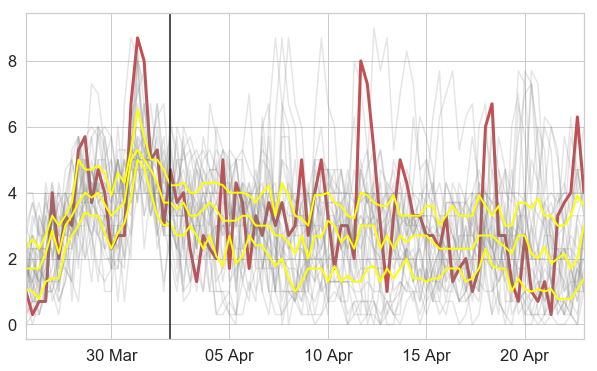

In [28]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(event_data[0], lw=3, c='r')
spp.applySmartTimeTicks(ax, event_data[0].index)
pred_data = []
for ii in ind.T:
    ttmp = vectors.iloc[ii].index[-1].to_pydatetime()
    tmin = ttmp-datetime.timedelta(hours=7*24+8)
    tmax = ttmp+datetime.timedelta(hours=21*24)
    print(ii, tmin, tmax)
    ax.plot(event_data[0].index, om_df['Kp'].loc[tmin:tmax], c='grey', alpha=0.2)
    pred_data.append(om_df['Kp'].loc[tmin:tmax].values)

ax.plot(event_data[0].index, np.percentile(pred_data, [25, 50, 75], axis=0).T, c='yellow', lw=2)
prediction = np.percentile(pred_data, [25, 50, 75], axis=0).T[:,1]
ax.axvline(events[0], c='k')

# Build a persistance data set
The last value stays for the whole period

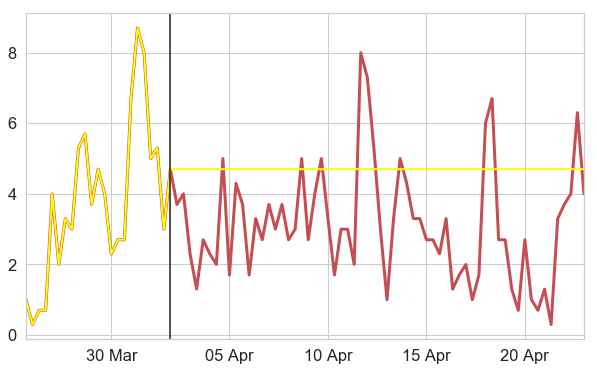

In [29]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(event_data[0], lw=3, c='r')
spp.applySmartTimeTicks(ax, event_data[0].index)

persistance = event_data[0].copy()
persistance.loc[events[0]:] = persistance.loc[events[0]]
ax.plot(persistance, lw=2, c='yellow')

ax.axvline(events[0], c='k')

# Metrics on the two models

In [34]:

def metrics(model, obs):
    metrics = {}
    metrics['bias'] = verify.bias(model, obs)
    #linear fit params and Pearson-r, model is y and obs are x (y = mx+c)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(obs, model)
    metrics['r'] = r_value
    metrics['Intercept'] = intercept
    metrics['Slope'] = slope
    # and more
    metrics['meanPercentageError'] = verify.meanPercentageError(model, obs)
    metrics['medianLogAccuracy'] = verify.medianLogAccuracy(model, obs)
    metrics['symmetricSignedBias'] = verify.symmetricSignedBias(model, obs)
    metrics['medSymAccuracy'] = verify.medSymAccuracy(model, obs)
    metrics['meanAPE'] = verify.meanAPE(model, obs)
    metrics['scaledAccuracy'] = verify.scaledAccuracy(model, obs)
    metrics['nRMSE'] = verify.nRMSE(model, obs)
    return metrics

def compare_metrics(model, ref):
    metrics = {}
    metrics['accuracy'] = verify.accuracy(model, ref)
    metrics['meanSquaredError'] = verify.meanSquaredError(model, ref)
    metrics['RMSE'] = verify.RMSE(model, ref)
    metrics['meanAbsError'] = verify.meanAbsError(model, ref)
    metrics['medAbsError'] = verify.medAbsError(model, ref)
#     metrics['skill'] = verify.skill(model, ref)
    return metrics
    
    


In [35]:
pred_metrics = metrics(prediction, event_data[0].values)
pred_metrics

/Users/balarsen/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/balarsen/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/balarsen/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/balarsen/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


{'bias': -0.4075581389804217,
 'r': 0.5564212719280157,
 'Intercept': 2.1265194544857833,
 'Slope': 0.23236818354927782,
 'meanPercentageError': 23.649430661673478,
 'medianLogAccuracy': -0.036812695686153724,
 'symmetricSignedBias': -8.846055633459526,
 'medSymAccuracy': 41.42135327963592,
 'meanAPE': 55.92744980648474,
 'scaledAccuracy': {'nRMSE': 0.17547995880973616,
  'MASE': 0.8782221956833404,
  'MAPE': 55.92744980648474,
  'MdAPE': 30.245855799418543,
  'MdSymAcc': 41.42135327963592},
 'nRMSE': 0.17547995880973616}

In [36]:
persist_metrics = metrics(persistance, event_data[0].values)
persist_metrics

/Users/balarsen/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/balarsen/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/balarsen/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/balarsen/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


{'bias': 1.1593021743519358,
 'r': 0.5349029371729919,
 'Intercept': 3.2896930258604202,
 'Slope': 0.3546544102240538,
 'meanPercentageError': 88.92652921243854,
 'medianLogAccuracy': 0.10389611064726693,
 'symmetricSignedBias': 27.027020234971168,
 'medSymAccuracy': 42.424238702372904,
 'meanAPE': 93.3242378042596,
 'scaledAccuracy': {'nRMSE': 0.26338509397420357,
  'MASE': 1.062372352016331,
  'MAPE': 93.3242378042596,
  'MdAPE': 38.4332225176871,
  'MdSymAcc': 42.424238702372904},
 'nRMSE': 0.26338509397420357}

In [37]:
compare_metrics(prediction, persistance)

{'accuracy': {'MSE': 3.631423806076858,
  'RMSE': 1.905629503884965,
  'MAE': 1.7680231048617252,
  'MdAE': 1.999999761581421},
 'meanSquaredError': 3.631423806076858,
 'RMSE': 1.905629503884965,
 'meanAbsError': 1.7680231048617252,
 'medAbsError': 1.999999761581421}